# Zero-Shot Learning for Record Linkage

## Load database

In [1]:
%load_ext autoreload
%autoreload 2

## Instantiate collection 

In [2]:
import re
import transformers  # old version '4.25.1'
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from itertools import combinations
from pyvis.network import Network
from random import shuffle
from collections import defaultdict, Counter
from tqdm.notebook import tqdm
from pathlib import Path
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotImageClassification
from tools.weaving_tools import SMGCollection,NMSCollection, classify_zero_shot, plot_images, VACollection, unique_substrings

In [3]:
tqdm.pandas()

In [4]:
collection = NMSCollection(device= 'mps',img_folder=Path('nms_imgs'))
collection.load_from_csv('data/NMS.csv')
collection.filter_records()

# Mapping Images to Taxonomies (NMS collection)

## Mistakes or enrichments?

In [5]:
checkpoint = 'openai/clip-vit-base-patch32'
model = AutoModelForZeroShotImageClassification.from_pretrained(checkpoint)
processor = AutoProcessor.from_pretrained(checkpoint)

In [33]:
matches = [re.search(r'[A-Z\-\s]+',str(t)) for t in collection.df.taxonomy.unique()]
matches = set([m.group().strip() for m in matches if m])
labels = list({i for i in matches if len(i) > 1})
print(labels)

['OFFICE EQUIPMENT', 'RAIL TRANSPORT', 'FERROUS METALS', 'TELECOMMUNICATIONS', 'DOMESTIC EQUIPMENT', 'CHEMISTRY', 'NON-FERROUS METALS', 'INDUSTRIES', 'SPORT', 'DOMESTIC', 'BT C', 'MEDICINE', 'CARTOGRAPHY', 'AERONAUTICS', 'PHYSICS', 'PNEUMATICS', 'AUDIO', 'MINING', 'MINERAL OILS', 'HEAT ENGINES', 'HYDRAULICS', 'EXPLOSIVES', 'MECHANICAL ENGINEERING', 'SHIPPING', 'CIVIL AND MECHANICAL ENGINEERING', 'ELECTRICAL AND ELECTRONIC ENGINEERING', 'GAS', 'CIVIL ENGINEERING', 'COMPUTING', 'PHOTOGRAPHY', 'TRANSPORT', 'ROAD TRANSPORT']


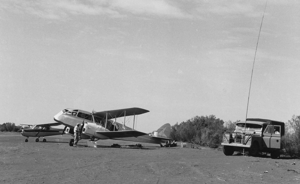

In [34]:
image = Image.open(collection.df.iloc[2010].img_path)
image.thumbnail((300,300))
image

In [36]:
labels = ['transport','communication','football']

In [37]:
inputs = processor(images=image, text=labels, return_tensors="pt", padding=True)

with torch.no_grad():
        outputs = model(**inputs)
    
logits = outputs.logits_per_image[0]

probs = logits.softmax(dim=-1).numpy()
print(sorted(list(zip(labels,list(probs))),key=lambda x:  x[1], reverse=True))

[('transport', 0.99518186), ('communication', 0.0044531184), ('football', 0.00036502146)]


In [9]:
collection.df['probs_by_label'] = collection.df.img_path.progress_apply(
                                                            classify_zero_shot, 
                                                            labels = labels,
                                                            model = model,
                                                            processor = processor)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


  0%|          | 0/4794 [00:00<?, ?it/s]

In [10]:
pattern = re.compile(r'[A-Z\-\s]+')
collection.df['y_true'] =  collection.df.taxonomy.apply(lambda x: set(i.strip() for i in pattern.findall(str(x)) if len(i.strip())>2))

In [11]:
n = 1
collection.df[f'y_pred_at_{n}'] = [set(res[i]['label'] 
                                        for i in range(n)) for res in collection.df['probs_by_label']
                                      ]

collection.df['overlap'] = collection.df.apply(
            lambda x: bool(x['y_true'].intersection(x[f'y_pred_at_{n}'])), axis=1
                    )

collection.df['overlap'].mean()

0.19566124322069253

In [12]:
collection.df['y_true_0'] = collection.df.apply(lambda x: list(x.y_true)[0] if x.y_true else '', axis=1)
by_y_true = collection.df.groupby(['y_true_0'])['overlap'].agg(['mean','count'])#mean()
by_y_true[by_y_true['count'] > 50].sort_values(ascending=False, by='mean')

,mean,count
y_true_0,,
MINERAL OILS,0.880952,84
FERROUS METALS,0.698324,179
OFFICE EQUIPMENT,0.567797,118
DOMESTIC EQUIPMENT,0.422222,135
RAIL TRANSPORT,0.368932,103
AERONAUTICS,0.240936,855
TELECOMMUNICATIONS,0.211740,477
SHIPPING,0.208333,144
HEAT ENGINES,0.206897,58


In [13]:
collection.df[['y_true', f'y_pred_at_{n}','overlap']]

,y_true,y_pred_at_1,overlap
0,{ROAD TRANSPORT},{NON-FERROUS METALS},False
1,{ROAD TRANSPORT},{NON-FERROUS METALS},False
2,{ROAD TRANSPORT},{ROAD TRANSPORT},True
3,"{INDUSTRIES, NON-FERROUS METALS}",{MINERAL OILS},False
4,"{INDUSTRIES, NON-FERROUS METALS}",{NON-FERROUS METALS},True
...,...,...,...
4789,{MINING},{AERONAUTICS},False
4790,{MINING},{OFFICE EQUIPMENT},False
4791,{MINING},{OFFICE EQUIPMENT},False
4792,{MINING},{OFFICE EQUIPMENT},False


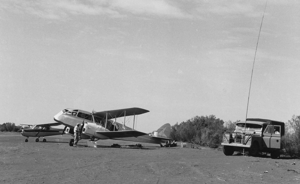

In [14]:
idx = 2010
img = Image.open(collection.df.iloc[idx]['img_path'])
img.thumbnail((300,300))
img

In [15]:
collection.df.iloc[idx][['y_true','probs_by_label']].values

array([{'AERONAUTICS'},
       list([{'score': 0.5126952528953552, 'label': 'AERONAUTICS'}, {'score': 0.27280867099761963, 'label': 'TRANSPORT'}, {'score': 0.0745823085308075, 'label': 'ROAD TRANSPORT'}, {'score': 0.019748931750655174, 'label': 'HYDRAULICS'}, {'score': 0.016208907589316368, 'label': 'BT C'}, {'score': 0.013685503974556923, 'label': 'MECHANICAL ENGINEERING'}, {'score': 0.013439323753118515, 'label': 'SHIPPING'}, {'score': 0.012643728405237198, 'label': 'CIVIL AND MECHANICAL ENGINEERING'}, {'score': 0.01213037595152855, 'label': 'DOMESTIC EQUIPMENT'}, {'score': 0.007515934761613607, 'label': 'INDUSTRIES'}, {'score': 0.007164891343563795, 'label': 'RAIL TRANSPORT'}, {'score': 0.006876688450574875, 'label': 'OFFICE EQUIPMENT'}, {'score': 0.0056249890476465225, 'label': 'TELECOMMUNICATIONS'}, {'score': 0.0034134010784327984, 'label': 'SPORT'}, {'score': 0.0025584022514522076, 'label': 'MINING'}, {'score': 0.0024773625191301107, 'label': 'MINERAL OILS'}, {'score': 0.00206363

## Mapping Images to Keyword (SMG, NMS and V&A Collection)

In [16]:
from keybert import KeyBERT
kw_model = KeyBERT()
#kw_model.extract_keywords(doc, keyphrase_ngram_range=(1, 2), stop_words=None)

In [17]:
smg = SMGCollection(device= 'mps',img_folder=Path('smg_imgs'))
smg.load_from_csv('data/SMG.csv')
smg.filter_records()
smg.df = smg.df.sample(frac=.1); smg.df.shape

(4629, 9)

In [18]:
nms = NMSCollection(device= 'mps',img_folder=Path('nms_imgs'))
nms.load_from_csv('data/NMS.csv')
nms.filter_records()

In [20]:
va = VACollection(device= 'mps',img_folder=Path('va_imgs'))
va.load_from_csv('data/VA.csv')
va.filter_records()
va.df = va.df[:4000]

In [21]:
def extract_image_keywords(collection,**kwargs):
    collection.df['description_clean'] = collection.df.description.apply(
                            lambda x: re.sub(re.compile(r'\b1[0-9]{3}\b'),'',x)
                                )
    
    collection.df['keyword'] = collection.df.description_clean.progress_apply(kw_model.extract_keywords,
                                            keyphrase_ngram_range=(1, 3), stop_words='english',
                                            use_maxsum=True, nr_candidates=10, top_n=5)
    
    collection.df['labels'] = collection.df['keyword'].apply(
                            lambda kws: [x[0] for x in kws]
                                )
    
    collection.df['probs_by_label'] = collection.df.progress_apply(
                            lambda x: classify_zero_shot(x.img_path, x.labels , model, processor) if x.labels else {}, 
                                axis=1
                            )
    return True


In [22]:
#extract_image_keywords(smg)
#extract_image_keywords(nms)
extract_image_keywords(va)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

True

In [23]:
filter_labels = lambda x: [e['label'] for e in x if e['score'] > .1]
#smg.df['top_labs'] = smg.df.probs_by_label.apply(filter_labels) 
#nms.df['top_labs'] = nms.df.probs_by_label.apply(filter_labels) 
va.df['top_labs'] = va.df.probs_by_label.apply(filter_labels) 

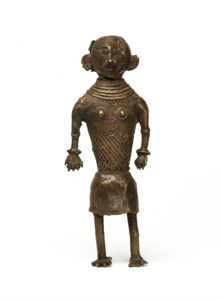

In [40]:
idx = 1001
coll = va
img = Image.open(coll.df.iloc[idx].img_path)
img.thumbnail((300,300))
img

In [41]:
print('DESCRIPTION\n')
print(coll.df.iloc[idx].description)
print()
print('KEYWORDS\n')
print(coll.df.iloc[idx].top_labs)
print()
print('ZERO SHOT RESULTS')
coll.df.iloc[idx]['probs_by_label']

DESCRIPTION

 A bronze sculpture of a female figure standing with her arms by her side. Bronze image of a female figure,  Kutiya Kond tribe, Orissa, India, ca. 1900. 

KEYWORDS

['female figure kutiya', 'female figure standing']

ZERO SHOT RESULTS


[{'score': 0.7285128831863403, 'label': 'female figure kutiya'},
 {'score': 0.12412617355585098, 'label': 'female figure standing'},
 {'score': 0.08864115178585052, 'label': 'standing arms bronze'},
 {'score': 0.04003890976309776, 'label': 'sculpture female'},
 {'score': 0.01868090033531189, 'label': 'arms bronze image'}]

# Creating an image-tag network

## prep data

### Add URLS

In [66]:
base_url = 'https://framemark.vam.ac.uk/collections/'
postfix = '/full/600,/0/default.jpg'
va.df['img_url'] = va.df.apply(lambda x: f'{base_url}{x.img_loc}{postfix}', axis=1)

smg.df['base_url'] = 'https://coimages.sciencemuseumgroup.org.uk/images/'
smg.df['img_url'] = smg.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)

nms.df['base_url'] = 'https://www.nms.ac.uk/search.axd?command=getcontent&server=Detail&value='
nms.df['img_url'] = nms.df.apply(lambda x: f'{x.base_url}{x.img_loc}', axis=1)

In [67]:
main_df = pd.concat([smg.df,nms.df,va.df], ignore_index=True, axis=0)
print(main_df.shape)
main_df[~main_df.top_labs.isnull()]
print(main_df.shape)
all_labels = [l for i, row in main_df.iterrows() for l in row.top_labs]
all_labels = Counter(all_labels)
all_labels =[k for k,v in all_labels.items() if v > 3]
print(len(all_labels))
#main_df.to_json('data/colab_export.json')

(13423, 16)
(13423, 16)
618


In [71]:
main_df['top_labs'] = main_df['top_labs'].apply(lambda x:[l for l in x if unique_substrings(l, x)])

In [72]:
tags = []
for i, row in main_df.iterrows():
    for l in row.top_labs:
        tags.append(l)
pd.DataFrame(Counter(tags).most_common(10), columns=['tag','frequency'])

,tag,frequency
0,monotype composition matrix,75
1,specimens illustrating copper,70
2,stereotype plate page,54
3,group copper ores,43
4,woodblocks illustrations used,43
5,glass,41
6,woodblock depicting,33
7,smelting extraction silver,29
8,collection woodblocks,27
9,engraving chinoiserie,27


In [73]:
keyword2img_url = defaultdict(list)
for i, row in main_df.iterrows():
    for l in row.top_labs:
        keyword2img_url[l].append(row.img_url)

In [74]:
keyword2img_path = defaultdict(list)
for i, row in main_df.iterrows():
    for l in row.top_labs:
        keyword2img_path[l].append(row.img_path)

### Example of node content

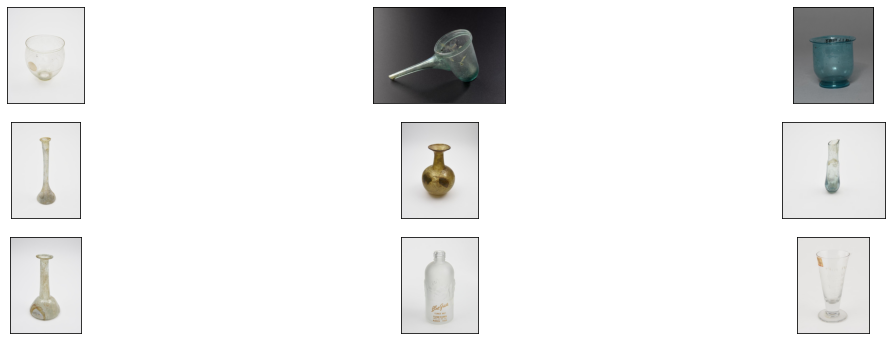

In [75]:
kw = 'glass'

imgs_kw =keyword2img_path[kw]
shuffle(imgs_kw)

fig = plt.figure(figsize=(20, 6))

columns = 3
rows = 3

for i in range(1, columns*rows +1):
            
    img = Image.open(imgs_kw[i-1])

    ax = fig.add_subplot(rows, columns, i,)
    ax.set_xticks([])
    ax.set_yticks([])
    plt.imshow(img)
plt.show()

In [76]:
net = Network(height="750px", 
              width="100%", 
              bgcolor="#222222", 
              font_color="white", 
              cdn_resources='remote', 
              #filter_menu=True, 
              notebook=True)



In [77]:
labs = set(all_labels).intersection(set(keyword2img_url.keys()))
len(labs)

596

In [79]:
for i, l in enumerate(labs):
    if not isinstance(keyword2img_url[l], float):
        net.add_node(i, shape='image', label=l, 
                     image = keyword2img_url[l][0], 
                     brokenImage='https://www.w3schools.com/w3css/img_lights.jpg',
                     title = '\n'.join(keyword2img_url[l])
                    )
        
len(net.nodes)

596

In [82]:
keyword2node_id = {l: i for i,l in enumerate(labs)}
for i, row in main_df.iterrows():
    labss = [l for l in set(row.top_labs) if l in labs]
    edges = combinations(labss,2)
    for s,t in edges:
        net.add_edge(keyword2node_id[s], keyword2node_id[t])
        
len(net.edges)

326

In [83]:
net.show("image_network_3.html")

image_network_3.html


# Fin.